#### Dataset used: https://www.kaggle.com/datasets/gabrielsantello/cars-purchase-decision-dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import packages
import pandas as pd
import numpy as np
import itertools
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, PredefinedSplit, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, plot_confusion_matrix

from cycler import cycler
from livelossplot.outputs import MatplotlibPlot
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Step 1: Load Dataset

In [2]:
################################ STEP 1: LOAD DATASET ################################
# Load dataset
data = pd.read_csv("car_data.csv")
# Visualize first five rows in the data
data.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


## Step 2: Data Pre-Processing

In [3]:
################################ STEP 2: DATA PRE-PROCESSING ################################

# Create DataFrame
df = pd.DataFrame(data)
# Drop User ID columns
df = df.drop(['User ID'], axis='columns') 
# Visualize first five rows in the updated data
df.head()

,Gender,Age,AnnualSalary,Purchased
0,Male,35,20000,0
1,Male,40,43500,0
2,Male,49,74000,0
3,Male,40,107500,1
4,Male,25,79000,0


In [4]:
# One-hot encoding for Gender column (Male/Female)
df = pd.get_dummies(df)

# Reorder columns for better visualization
df = df[['Age', 'AnnualSalary', 'Gender_Female', 'Gender_Male', 'Purchased']]
# Visualize first five rows in the updated data
df.head()

,Age,AnnualSalary,Gender_Female,Gender_Male,Purchased
0,35,20000,0,1,0
1,40,43500,0,1,0
2,49,74000,0,1,0
3,40,107500,0,1,1
4,25,79000,0,1,0


In [5]:
# Generate AgeGroup Feature
# Adult(18-39), MidAge(40-59), Senior(60+)
bins= [df.Age.min(),40,60,df.Age.max()+1]
labels = ['Adult','MidAge','Senior']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df.head()

,Age,AnnualSalary,Gender_Female,Gender_Male,Purchased,AgeGroup
0,35,20000,0,1,0,Adult
1,40,43500,0,1,0,MidAge
2,49,74000,0,1,0,MidAge
3,40,107500,0,1,1,MidAge
4,25,79000,0,1,0,Adult


In [6]:
# Generate IncomeGroup Feature
# LowIncome(<32000), MidIncome(32000-99999), HighIncome(>=100000)
bins= [0,32000,100000,df.AnnualSalary.max()+1]
labels = ['LowIncome','MidIncome','HighIncome']
df['IncomeGroup'] = pd.cut(df['AnnualSalary'], bins=bins, labels=labels, right=False)
df.head()

,Age,AnnualSalary,Gender_Female,Gender_Male,Purchased,AgeGroup,IncomeGroup
0,35,20000,0,1,0,Adult,LowIncome
1,40,43500,0,1,0,MidAge,MidIncome
2,49,74000,0,1,0,MidAge,MidIncome
3,40,107500,0,1,1,MidAge,HighIncome
4,25,79000,0,1,0,Adult,MidIncome


In [7]:
# One-hot encoding for generated Age and Income groups
df = pd.get_dummies(df)

# Rename columns
df=df.rename(columns = {'AgeGroup_Adult':'Adult','AgeGroup_MidAge':'MidAge','AgeGroup_Senior':'Senior',
                       'IncomeGroup_LowIncome':'LowIncome','IncomeGroup_MidIncome':'MidIncome',
                       'IncomeGroup_HighIncome':'HighIncome'})
# Reorder columns for better visualization
df = df[['Age', 'AnnualSalary', 'Gender_Female', 'Gender_Male', 'Adult', 'MidAge', 'Senior',
        'LowIncome', 'MidIncome', 'HighIncome', 'Purchased']]
# Visualize first five rows in the updated data
df.head()

,Age,AnnualSalary,Gender_Female,Gender_Male,Adult,MidAge,Senior,LowIncome,MidIncome,HighIncome,Purchased
0,35,20000,0,1,1,0,0,1,0,0,0
1,40,43500,0,1,0,1,0,0,1,0,0
2,49,74000,0,1,0,1,0,0,1,0,0
3,40,107500,0,1,0,1,0,0,0,1,1
4,25,79000,0,1,1,0,0,0,1,0,0


In [8]:
# Split data into inputs and outputs
X = df.drop('Purchased', axis='columns')
y = df.Purchased

# Split data into training/testing sets with 70%/20%/10% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 1234)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=int(df.shape[0]*0.2), random_state = 1234)

In [9]:
# Create z-normalization function
def normalizeData(data, mean, std):
    normalized = (data-mean)/(std)
    return normalized

# Create denormalization function
def denormalizeData(normalized_data, mean, std):
    denormalized = (normalized_data*std)+(mean)
    return denormalized

In [10]:
# Mean and standard deviation of training set
Xtrain_mean = np.mean(X_train)
Xtrain_std = np.std(X_train)

In [11]:
# Normalize data
Xtrain_norm = normalizeData(X_train, Xtrain_mean, Xtrain_std)
Xval_norm = normalizeData(X_val, Xtrain_mean, Xtrain_std)
Xtest_norm = normalizeData(X_test, Xtrain_mean, Xtrain_std)

## Step 3: Multi-Layer Preceptron Model (MLP Classifier)

In [12]:
# Load MLP model
MLP_model = MLPClassifier()

# Create parameters grid for parameters that will be tuned
param_grid = [{
    # Five hidden layers & tuning number of neurons in each hidden layer between 25 and 50
    "hidden_layer_sizes": [x for x in itertools.product((25,50),repeat=5)], 
    "activation": ["logistic", "tanh", "relu"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate_init": [0.0001, 0.001, 0.01, 0.1],
    "solver": ["sgd"]
}]

# Start Grid Search
param_search = GridSearchCV(MLP_model, param_grid, cv=5, scoring="accuracy", verbose=2)
param_search.fit(Xtrain_norm, y_train)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] 

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activ

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activatio

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activati

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activa

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END ac

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END 

[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] E

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.0s
[CV] END a

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END 

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.1s
[CV] END 

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.0s
[CV] END

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activa

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activatio

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activatio

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=l

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=l

[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.1s
[CV] END activation=log

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=logistic

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=logistic

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.3s
[CV] END activation=logis

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=logistic

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=logistic, 

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=logistic

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=logistic, 

[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, al

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, al

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic,

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=logistic,

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.3s
[CV] END activation=logistic,

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=logistic,

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=logistic,

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.2s
[CV] END activation=logistic,

[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.1s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidd

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, h

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.001,

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.00

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001,

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, 

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hi

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidd

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidde

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_si

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_size

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(2

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_si

[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   2.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_size

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_si

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_s

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_si

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_siz

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(5

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   2.0s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50

[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   2.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   2.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.0001,

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_la

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_laye

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_s

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.001, hidden_lay

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.001, hidd

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.5s
[CV] END activation=relu, alpha=0.001, h

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 25, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.01, hidden

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 25, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.01, hidden_l

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(25, 50, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.01, hidden_lay

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.01, hidden_layer

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 25, 50, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_s

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.001, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 25, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_si

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_size

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25,

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.01, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 50, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 25, 5

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.01, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 25, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 25

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.01, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   1.0s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(25, 50, 50, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 25), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.0s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 25, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 25, 50), learning_rate_init=0.1, solver=sgd; total time=   0.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 25, 50, 50, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 25), learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 25, 50), learning_rate_init=0.0001, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_size

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 25, 50, 50), learning_rate_init=0.1, solver=sgd; total time=   0.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.0001, solver=sgd; total time=   1.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 25, 25), learning_rate_init=0.001, solver=sgd; total time=   1.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_si

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.0001, solver=sgd; total time=   2.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   2.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate_init=0.001, solver=sgd; total time=   2.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid=[{'activation': ['logistic', 'tanh', 'relu'],
                          'alpha': [0.0001, 0.001, 0.01, 0.1],
                          'hidden_layer_sizes': [(25, 25, 25, 25, 25),
                                                 (25, 25, 25, 25, 50),
                                                 (25, 25, 25, 50, 25),
                                                 (25, 25, 25, 50, 50),
                                                 (25, 25, 50, 25, 25),
                                                 (25, 25, 50, 25, 50),
                                                 (25, 25, 50, 50, 25),
                                                 (25, 25, 50, 50, 50),
                                                 (25, 50, 25, 25, 25),
                                                 (25, 50, 25, 25, 50),
                                                 (25, 50, 25, 50, 25),
                                        

In [13]:
# Print out best parameters
best_MLP = param_search.best_params_
best_MLP

{'activation': 'relu',
 'alpha': 0.1,
 'hidden_layer_sizes': (25, 50, 25, 50, 50),
 'learning_rate_init': 0.01,
 'solver': 'sgd'}

In [14]:
# Save best parameters to variable
bestMLP_model = MLPClassifier(**param_search.best_params_)

In [15]:
# Train MLP model with best parameters for 150 epochs
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 150
N_BATCH = 128
N_CLASSES = np.unique(y_train)

scores_train = []
scores_val = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    # SHUFFLING
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        bestMLP_model.partial_fit(Xtrain_norm.loc[Xtrain_norm.index.isin(indices)], 
                        y_train.loc[y_train.index.isin(indices)], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(bestMLP_model.score(Xtrain_norm, y_train))

    # SCORE VALIDATION
    scores_val.append(bestMLP_model.score(Xval_norm, y_val))

    epoch += 1

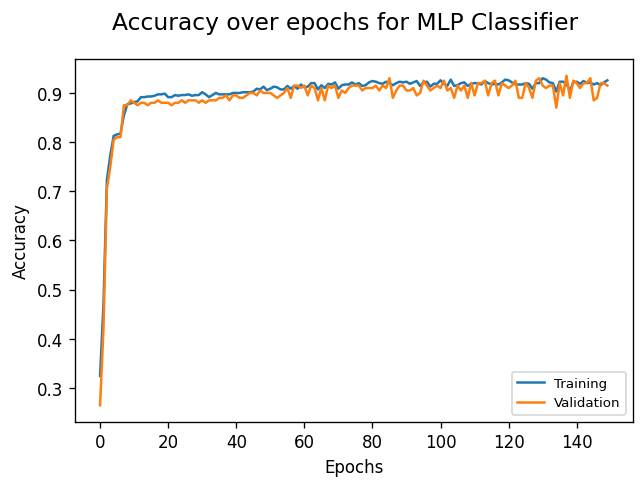

In [16]:
# Plot Accuracy measures while training for 150 epochs for the tuned model
fig, ax = plt.subplots(dpi=120)
ax.plot(scores_train, label='Training')
ax.plot(scores_val, label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle("Accuracy over epochs for MLP Classifier", fontsize=14)
plt.legend(fontsize=8, loc='lower right')
plt.show()

In [17]:
# Get predictions on test data
MLP_fitted = bestMLP_model.fit(Xtrain_norm, y_train)
MLP_predictions = MLP_fitted.predict(Xtest_norm)

In [18]:
# Calculate performance measures
# TP: true postives 
# TN: true negatives 
# FP: False positives 
# FN: False negatives
def compute_performance(yhat, y, classes):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    precision = tp / (tp + fp)
    
    # Recall
    recall = tp / (tp + fn)    
    
    # Sensitivity
    sensitivity = recall
    
    # Specificity
    specificity = tn / (fp + tn)
    
    # Print results
    print("Accuracy:",round(acc,3),"Recall:",round(recall,3),"Precision:",round(precision,3),
          "Sensitivity:",round(sensitivity,3),"Specificity:",round(specificity,3))

# Compute metrics
compute_performance(MLP_predictions, y_test, MLP_fitted.classes_)

tp: 32 tn: 57 fp: 8 fn: 3
Accuracy: 0.89 Recall: 0.914 Precision: 0.8 Sensitivity: 0.914 Specificity: 0.877


Text(0.5, 1.0, 'MLP Classifier')

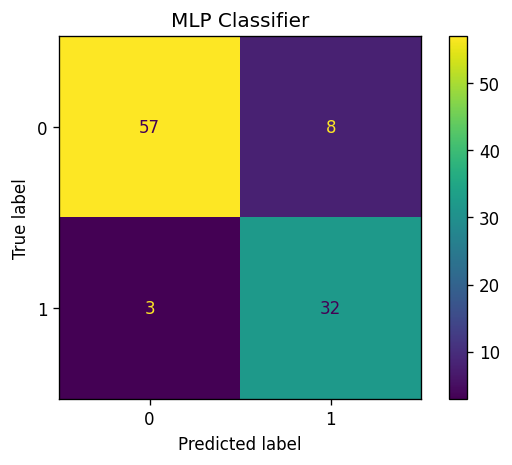

In [19]:
# Generate Confusion Matrix
fig, ax = plt.subplots(dpi=120)
plot_confusion_matrix(MLP_fitted, Xtest_norm, y_test, ax=ax)
ax.set_title('MLP Classifier')

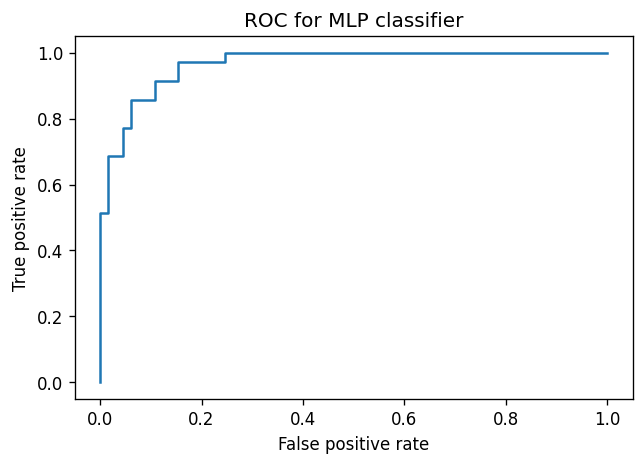

In [20]:
# ROC Plot for MLP
fig, ax = plt.subplots(dpi = 120)
ROC_all = MLP_fitted.predict_proba(Xtest_norm)
ROC_X1, ROC_y1, _ = roc_curve(y_test, ROC_all[:,1])
ax.plot(ROC_X1, ROC_y1)
plt.title("ROC for MLP classifier")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

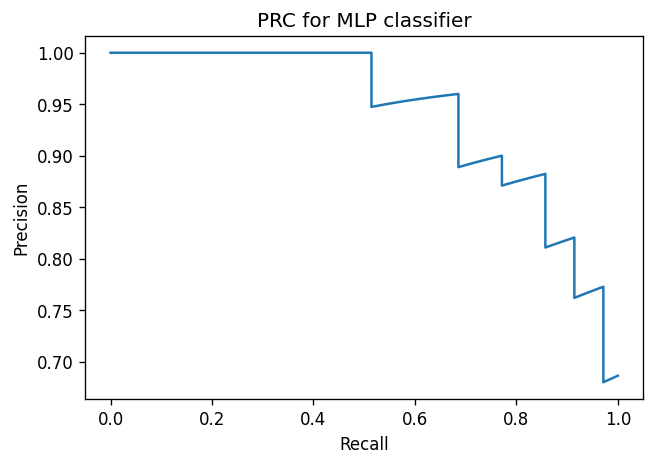

In [21]:
# PRC for all-variable classifier
fig, ax = plt.subplots(dpi = 120)
Precision_all, Recall_all, _ = precision_recall_curve(y_test, ROC_all[:,1])
ax.plot(Recall_all, Precision_all)
plt.title("PRC for MLP classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Step 4: SGD Classifier

In [22]:
# Load SGD Logistic Regression model
model2 = SGDClassifier(loss="modified_huber")

In [23]:
# Train basic SGD model for 150 epochs and plot corresponding training and validation accuracy values

n_samples = Xtrain_norm.shape[0]
n_epochs = 150
batch_size = 128
n_classes = np.unique(y_train)

scores_train2 = []
scores_val2 = []

epoch = 0
while epoch < n_epochs:
    # Shuffle
    random_perm = np.random.permutation(Xtrain_norm.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + batch_size]
        model2.partial_fit(Xtrain_norm.loc[Xtrain_norm.index.isin(indices)], 
                                  y_train.loc[y_train.index.isin(indices)], classes=n_classes)
        mini_batch_index += batch_size

        if mini_batch_index >= n_samples:
            break

    # Train accuracy
    scores_train2.append(model2.score(Xtrain_norm, y_train))

    # Validation accuracy
    scores_val2.append(model2.score(Xval_norm, y_val))
    
    epoch += 1

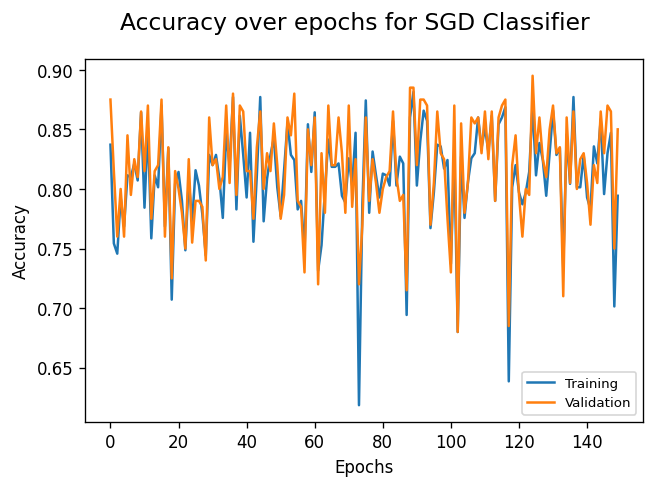

In [24]:
# Plot Accuracy measures while training for 150 epochs for the tuned model
fig, ax = plt.subplots(dpi=120)
ax.plot(scores_train2, label='Training')
ax.plot(scores_val2, label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle("Accuracy over epochs for SGD Classifier", fontsize=14)
plt.legend(fontsize=8, loc='lower right')
plt.show()

In [25]:
# Get predictions on test data
model2_fitted = model2.fit(Xtrain_norm, y_train)
model2_predictions = model2_fitted.predict(Xtest_norm)

In [26]:
# Compute metrics
compute_performance(model2_predictions, y_test, model2_fitted.classes_)

tp: 34 tn: 35 fp: 30 fn: 1
Accuracy: 0.69 Recall: 0.971 Precision: 0.531 Sensitivity: 0.971 Specificity: 0.538


Text(0.5, 1.0, 'SGD Classifier')

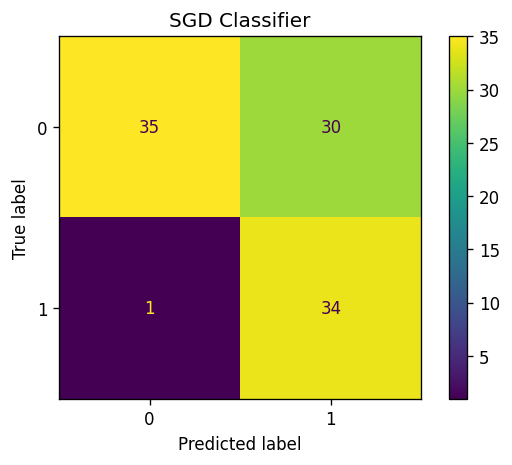

In [27]:
# Plot the confusion matrix
fig, ax = plt.subplots(dpi=120)
plot_confusion_matrix(model2_fitted, Xtest_norm, y_test, ax=ax)
ax.set_title('SGD Classifier')

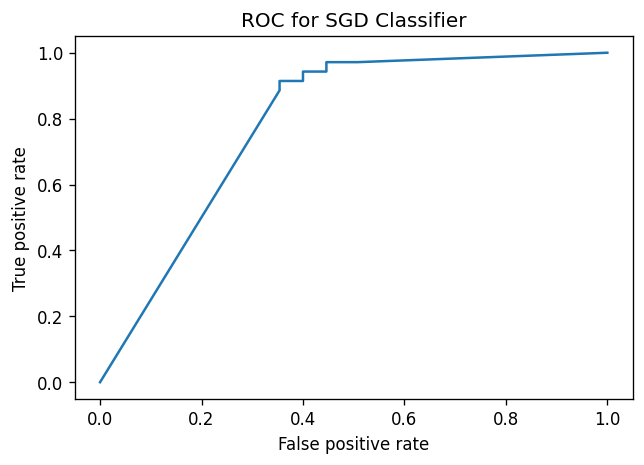

In [28]:
# ROC Plot for SGD Logistic Regression
fig, ax = plt.subplots(dpi = 120)
ROC_all_model2 = model2_fitted.predict_proba(Xtest_norm)
ROC_X1_model2, ROC_y1_model2, _ = roc_curve(y_test, ROC_all_model2[:,1])
ax.plot(ROC_X1_model2, ROC_y1_model2)
plt.title("ROC for SGD Classifier")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

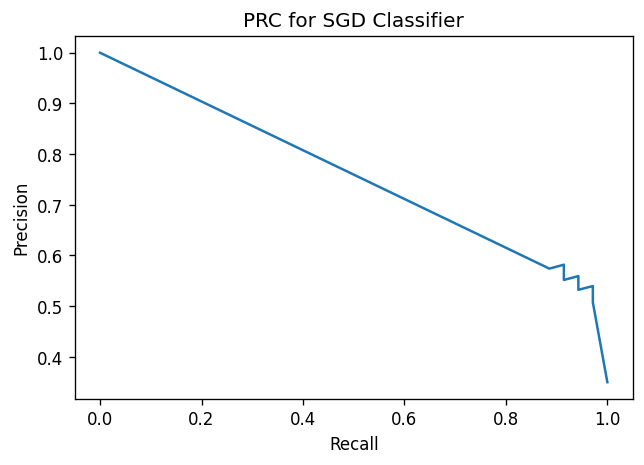

In [29]:
# PRC for SGD Logistic Regression
fig, ax = plt.subplots(dpi = 120)
Precision_all_model2, Recall_all_model2, _ = precision_recall_curve(y_test, ROC_all_model2[:,1])
ax.plot(Recall_all_model2, Precision_all_model2)
plt.title("PRC for SGD Classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()